In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generating synthetic data
date_range = pd.date_range(start='2015-01-01', periods=2500, freq='D')
temperature = 20 + np.sin(np.linspace(0, 100, 2500)) + np.random.normal(0, 0.5, 2500)

# Add some anomalies
temperature[100:110] += 8  # Sudden spike
temperature[1200:1210] -= 6  # Sudden drop

# Create a DataFrame
df = pd.DataFrame({'Date': date_range, 'Temperature': temperature})
df.head(20)


,Date,Temperature
0,2015-01-01,20.248357
1,2015-01-02,19.970873
2,2015-01-03,20.403791
3,2015-01-04,20.881275
4,2015-01-05,20.042305
5,2015-01-06,20.081679
6,2015-01-07,21.027402
7,2015-01-08,20.660181
8,2015-01-09,20.079951
9,2015-01-10,20.623689





*   It Generates 2500 synthetic temperature readings over a date range from start date 2015/01/01 to 2022 span of 2 years including some random anomalies (spikes and drops) to simulate real-world irregularities


In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize the temperature data
scaler = MinMaxScaler()
df['Temperature'] = scaler.fit_transform(df[['Temperature']])

# Convert to a supervised learning problem (LSTM input requires sequences)
def create_sequences(data, sequence_length=30):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 30
temperature_sequences = create_sequences(df['Temperature'].values)

# Split into training and testing sets
X_train, X_test = train_test_split(temperature_sequences, test_size=0.2, random_state=42)


**Normalization:**


*    Scales temperature values between 0 and 1 for better performance.
Sequence Creation: Converts time series data into overlapping sequences for LSTM input.
*   Train-Test Split: Splits the data into training and testing sets (80% train, 20% test).






In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Define LSTM Autoencoder architecture
timesteps = X_train.shape[1]
features = 1

# Encoder
inputs = Input(shape=(timesteps, features))
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
latent = RepeatVector(timesteps)(encoded)

# Decoder
decoded = LSTM(64, activation='relu', return_sequences=True)(latent)
output = TimeDistributed(Dense(features))(decoded)

# Model
autoencoder = Model(inputs, output)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

**Encoder**


*   
Compresses the input temperature sequence into a lower-dimensional latent space


**Decoder:**


*   
 Reconstructs the original input from the latent space.
The autoencoder is designed to learn normal patterns and minimize reconstruction error for normal data




In [5]:
# Reshape the data for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], features))

# Train the model
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32,
                          validation_split=0.1, shuffle=True)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.1210 - val_loss: 0.0134
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0108 - val_loss: 0.0047
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0


*   Trains the LSTM Autoencoder using mean squared error (MSE) as the loss function.
Monitors training and validation loss to ensure the model learns effectively



In [6]:
# Predict reconstruction on the test set
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - X_test_pred), axis=(1, 2))

# Define threshold as mean + 2 standard deviations of MSE
threshold = np.mean(mse) + 2 * np.std(mse)

# Identify anomalies
anomalies = mse > threshold
anomaly_indices = np.where(anomalies)[0]
print("Number of anomalies detected:", len(anomaly_indices))


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Number of anomalies detected: 14


After training acroos 16 batches

*   The LSTM Autoencoder identified 14 anomalies in the test dataset.
These anomalies are instances where the temperature deviates significantly from the learned normal patterns







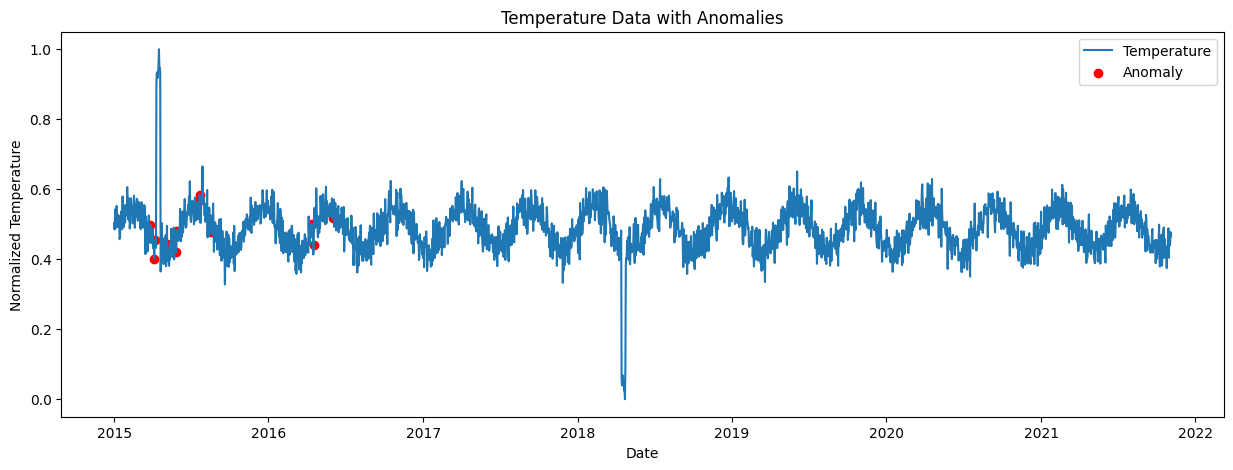

In [7]:
# Plot the original temperature data and highlight anomalies
plt.figure(figsize=(15, 5))
plt.plot(df['Date'], df['Temperature'], label='Temperature')
plt.scatter(df['Date'][anomaly_indices + sequence_length],
            df['Temperature'][anomaly_indices + sequence_length],
            color='red', label='Anomaly', marker='o')
plt.title('Temperature Data with Anomalies')
plt.xlabel('Date')
plt.ylabel('Normalized Temperature')
plt.legend()
plt.show()


**PLOT INTERPRETATION**

Time Series Pattern:


*   
The blue line represents the normalized temperature readings over time (from 2015 to 2022).
*   
The temperature data exhibits a cyclical/seasonal pattern, which is typical in weather data due to seasonal variations.


Anomaly Detection:


*   The red dots highlight the detected anomalies in the temperature data.
*   Anomalies are identified as instances where the reconstruction error from the LSTM autoencoder exceeds a defined threshold.



Significance of Anomalies:


*   
Early 2015: A significant spike in temperature is detected as anomalous. This could indicate a sudden heatwave or sensor malfunction.
*   2018: A sharp drop in temperature is also identified as an anomaly, potentially indicating an extreme cold event or data inconsistency.

*   
Scattered anomalies: Smaller anomalies scattered throughout the time series could indicate unusual temperature fluctuations.








**Overall Insight:**

The LSTM Autoencoder successfully identified both major and minor deviations from the normal temperature patterns.
These anomalies could represent important events such as extreme weather conditions, sensor errors, or data outliers.